## Loading the data

In [1]:
import pandas as pd
import numpy as np

# Load comments data
com_airing = pd.read_csv('comments/airing_comments.csv')
com_post_airing = pd.read_csv('comments/post_airing_comments.csv')
com_pre_release = pd.read_csv('comments/pre_release_comments.csv')

# Load node level data
node_airing = pd.read_csv('node/airing_node_information.csv')
node_post_airing = pd.read_csv('node/post_airing_node_information.csv')
node_pre_release = pd.read_csv('node/pre_release_node_information.csv')

# Load clique and core data
clique_airing = pd.read_csv('clique & core/airing_node_cliqueandcoreinformation.csv')
clique_post_airing = pd.read_csv('clique & core/post_airing_node_kcliquesandcores.csv')
clique_pre_release = pd.read_csv('clique & core/pre_release_cliqueandcore_info.csv')

clique_airing

,Node,1-Core,2-Core,3-Core,4-Core,5-Core,6-Core,7-Core,8-Core,3-Clique,...,7-Clique,8-Clique,Betweenness,Closeness,Degree Centrality,Degree,#Submissions,#Comments,#Comments on Submissions,#Comments on Comments
0,The72nd,1,0,0,0,0,0,0,0,0,...,0,0,0.000000,0.000000,0.002941,1.0,0.0,1.0,0.0,0.0
1,BogerFrank981,1,0,0,0,0,0,0,0,0,...,0,0,0.002004,0.002941,0.005882,2.0,0.0,2.0,0.0,1.0
2,deepcontractor,1,1,1,1,1,1,0,0,1,...,0,0,0.046501,0.272048,0.111765,38.0,6.0,17.0,23.0,9.0
3,thehornedlamb,1,1,0,0,0,0,0,0,0,...,0,0,0.002907,0.200262,0.011765,4.0,1.0,2.0,2.0,1.0
4,purpletube5678,1,0,0,0,0,0,0,0,0,...,0,0,0.000000,0.000000,0.002941,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,FogellMcLovin77,1,0,0,0,0,0,0,0,0,...,0,0,0.000000,0.000000,0.002941,1.0,0.0,1.0,0.0,0.0
337,GrandmasterJanus,1,0,0,0,0,0,0,0,0,...,0,0,0.000000,0.000000,0.002941,1.0,0.0,1.0,0.0,0.0
338,jimboswaggerman,1,0,0,0,0,0,0,0,0,...,0,0,0.000000,0.204621,0.002941,1.0,0.0,0.0,0.0,1.0
339,kpps14red,1,0,0,0,0,0,0,0,0,...,0,0,0.000000,0.138487,0.005882,2.0,0.0,1.0,0.0,1.0


In [2]:
# print unique Child IDs in com_airing
print('Unique Child IDs in com_airing: ', com_airing['Child ID'].nunique())
print('Unique Nodes in node_airing: ', node_airing['Node'].nunique())

Unique Child IDs in com_airing:  290
Unique Nodes in node_airing:  341


## Computing average sentiment score for each user using Vader

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()

def calculate_sentiment(df, text_column, id_column):
    df = df[[id_column, text_column]].copy()

    def get_sentiment_score(text):
        return vader.polarity_scores(text)['compound']
    
    df['sentiment_score'] = df[text_column].apply(get_sentiment_score)
    df = df.drop(columns=[text_column])
    df = df.groupby(id_column).mean().reset_index()
    df = df.rename(columns={id_column: 'Node'})

    return df

sentiment_airing = calculate_sentiment(com_airing, 'body', 'Child ID')
sentiment_post_airing = calculate_sentiment(com_post_airing, 'body', 'Child ID')
sentiment_pre_release = calculate_sentiment(com_pre_release, 'body', 'Child ID')

## Computing total score for each user

In [4]:
def total_score(df, score_column, id_column):
    df = df[[id_column, score_column]].copy()
    df = df.groupby(id_column).sum().reset_index()
    df = df.rename(columns={id_column: 'Node'})


    return df

total_score_airing = total_score(com_airing, 'score', 'Child ID')
total_score_post_airing = total_score(com_post_airing, 'score', 'Child ID')
total_score_pre_release = total_score(com_pre_release, 'score', 'Child ID')

## Joining the new features at node level

In [5]:
# Merge sentiment and total score with node data
node_airing = node_airing.merge(sentiment_airing, on='Node', how='left')
node_airing = node_airing.merge(total_score_airing, on='Node', how='left')

node_post_airing = node_post_airing.merge(sentiment_post_airing, on='Node', how='left')
node_post_airing = node_post_airing.merge(total_score_post_airing, on='Node', how='left')

node_pre_release = node_pre_release.merge(sentiment_pre_release, on='Node', how='left')
node_pre_release = node_pre_release.merge(total_score_pre_release, on='Node', how='left')


# impute missing values, for sentiment_score = 0, for score = average score
node_airing['sentiment_score'] = node_airing['sentiment_score'].fillna(0)
node_airing['score'] = node_airing['score'].fillna(node_airing['score'].mean())

node_post_airing['sentiment_score'] = node_post_airing['sentiment_score'].fillna(0)
node_post_airing['score'] = node_post_airing['score'].fillna(node_post_airing['score'].mean())

node_pre_release['sentiment_score'] = node_pre_release['sentiment_score'].fillna(0)
node_pre_release['score'] = node_pre_release['score'].fillna(node_pre_release['score'].mean())

## Adding clique and core information

In [6]:
clique_airing = clique_airing.drop(columns=['1-Core', 'Betweenness', 'Closeness', 'Degree Centrality', 'Degree', '#Submissions', '#Comments', '#Comments on Submissions', '#Comments on Comments'])
clique_post_airing = clique_post_airing.drop(columns=['1-Core', 'Betweenness', 'Closeness', 'Degree Centrality', 'Degree', '#Submissions', '#Comments', '#Comments on Submissions', '#Comments on Comments'])
clique_pre_release = clique_pre_release.drop(columns=['1-Core', 'Betweenness', 'Closeness', 'Degree Centrality', 'Degree', '#Submissions', '#Comments', '#Comments on Submissions', '#Comments on Comments'])

print(clique_airing.columns)
print(clique_post_airing.columns)
print(clique_pre_release.columns)

# add missing columns: clique form 3-clique up to 8-clique and core form 2-core up to 8-core as zeros if not exist (for clique_airing, clique_post_airing, clique_pre_release)

datasets = [clique_airing, clique_post_airing, clique_pre_release]

for dataset in datasets:
    for i in range(3, 9):
        if f'{i}-Clique' not in dataset.columns:
            dataset[f'{i}-Clique'] = 0
    for i in range(2, 9):
        if f'{i}-Core' not in dataset.columns:
            dataset[f'{i}-Core'] = 0

print('New columns added to clique_airing, clique_post_airing, clique_pre_release :')
print(clique_airing.columns)
print(clique_post_airing.columns)
print(clique_pre_release.columns)

Index(['Node', '2-Core', '3-Core', '4-Core', '5-Core', '6-Core', '7-Core',
       '8-Core', '3-Clique', '4-Clique', '5-Clique', '6-Clique', '7-Clique',
       '8-Clique'],
      dtype='object')
Index(['Node', '2-Core', '3-Core', '3-Clique', '4-Clique'], dtype='object')
Index(['Node', '2-Core', '3-Core', '4-Core', '5-Core', '6-Core', '7-Core',
       '8-Core', '3-Clique', '4-Clique', '5-Clique', '6-Clique', '7-Clique'],
      dtype='object')
New columns added to clique_airing, clique_post_airing, clique_pre_release :
Index(['Node', '2-Core', '3-Core', '4-Core', '5-Core', '6-Core', '7-Core',
       '8-Core', '3-Clique', '4-Clique', '5-Clique', '6-Clique', '7-Clique',
       '8-Clique'],
      dtype='object')
Index(['Node', '2-Core', '3-Core', '3-Clique', '4-Clique', '5-Clique',
       '6-Clique', '7-Clique', '8-Clique', '4-Core', '5-Core', '6-Core',
       '7-Core', '8-Core'],
      dtype='object')
Index(['Node', '2-Core', '3-Core', '4-Core', '5-Core', '6-Core', '7-Core',
       '8-Core'

## Merging the cliques and cores to our dataset

In [7]:
# Merge node data with clique and core data
node_airing = node_airing.merge(clique_airing, on='Node', how='left')
node_post_airing = node_post_airing.merge(clique_post_airing, on='Node', how='left')
node_pre_release = node_pre_release.merge(clique_pre_release, on='Node', how='left')

In [8]:
node_airing

,Node,Betweenness,Closeness,Degree Centrality,Degree,#Submissions,#Comments,#Comments on Submissions,#Comments on Comments,sentiment_score,...,5-Core,6-Core,7-Core,8-Core,3-Clique,4-Clique,5-Clique,6-Clique,7-Clique,8-Clique
0,The72nd,0.000000,0.000000,0.002941,1.0,0.0,1.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,BogerFrank981,0.002004,0.002941,0.005882,2.0,0.0,2.0,0.0,1.0,0.394950,...,0,0,0,0,0,0,0,0,0,0
2,deepcontractor,0.046501,0.272048,0.111765,38.0,6.0,17.0,23.0,9.0,0.155741,...,1,1,0,0,1,1,0,0,0,0
3,thehornedlamb,0.002907,0.200262,0.011765,4.0,1.0,2.0,2.0,1.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,purpletube5678,0.000000,0.000000,0.002941,1.0,0.0,1.0,0.0,0.0,0.371600,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,FogellMcLovin77,0.000000,0.000000,0.002941,1.0,0.0,1.0,0.0,0.0,-0.680800,...,0,0,0,0,0,0,0,0,0,0
337,GrandmasterJanus,0.000000,0.000000,0.002941,1.0,0.0,1.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
338,jimboswaggerman,0.000000,0.204621,0.002941,1.0,0.0,0.0,0.0,1.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
339,kpps14red,0.000000,0.138487,0.005882,2.0,0.0,1.0,0.0,1.0,0.000000,...,0,0,0,0,0,0,0,0,0,0


# Correlation matrix

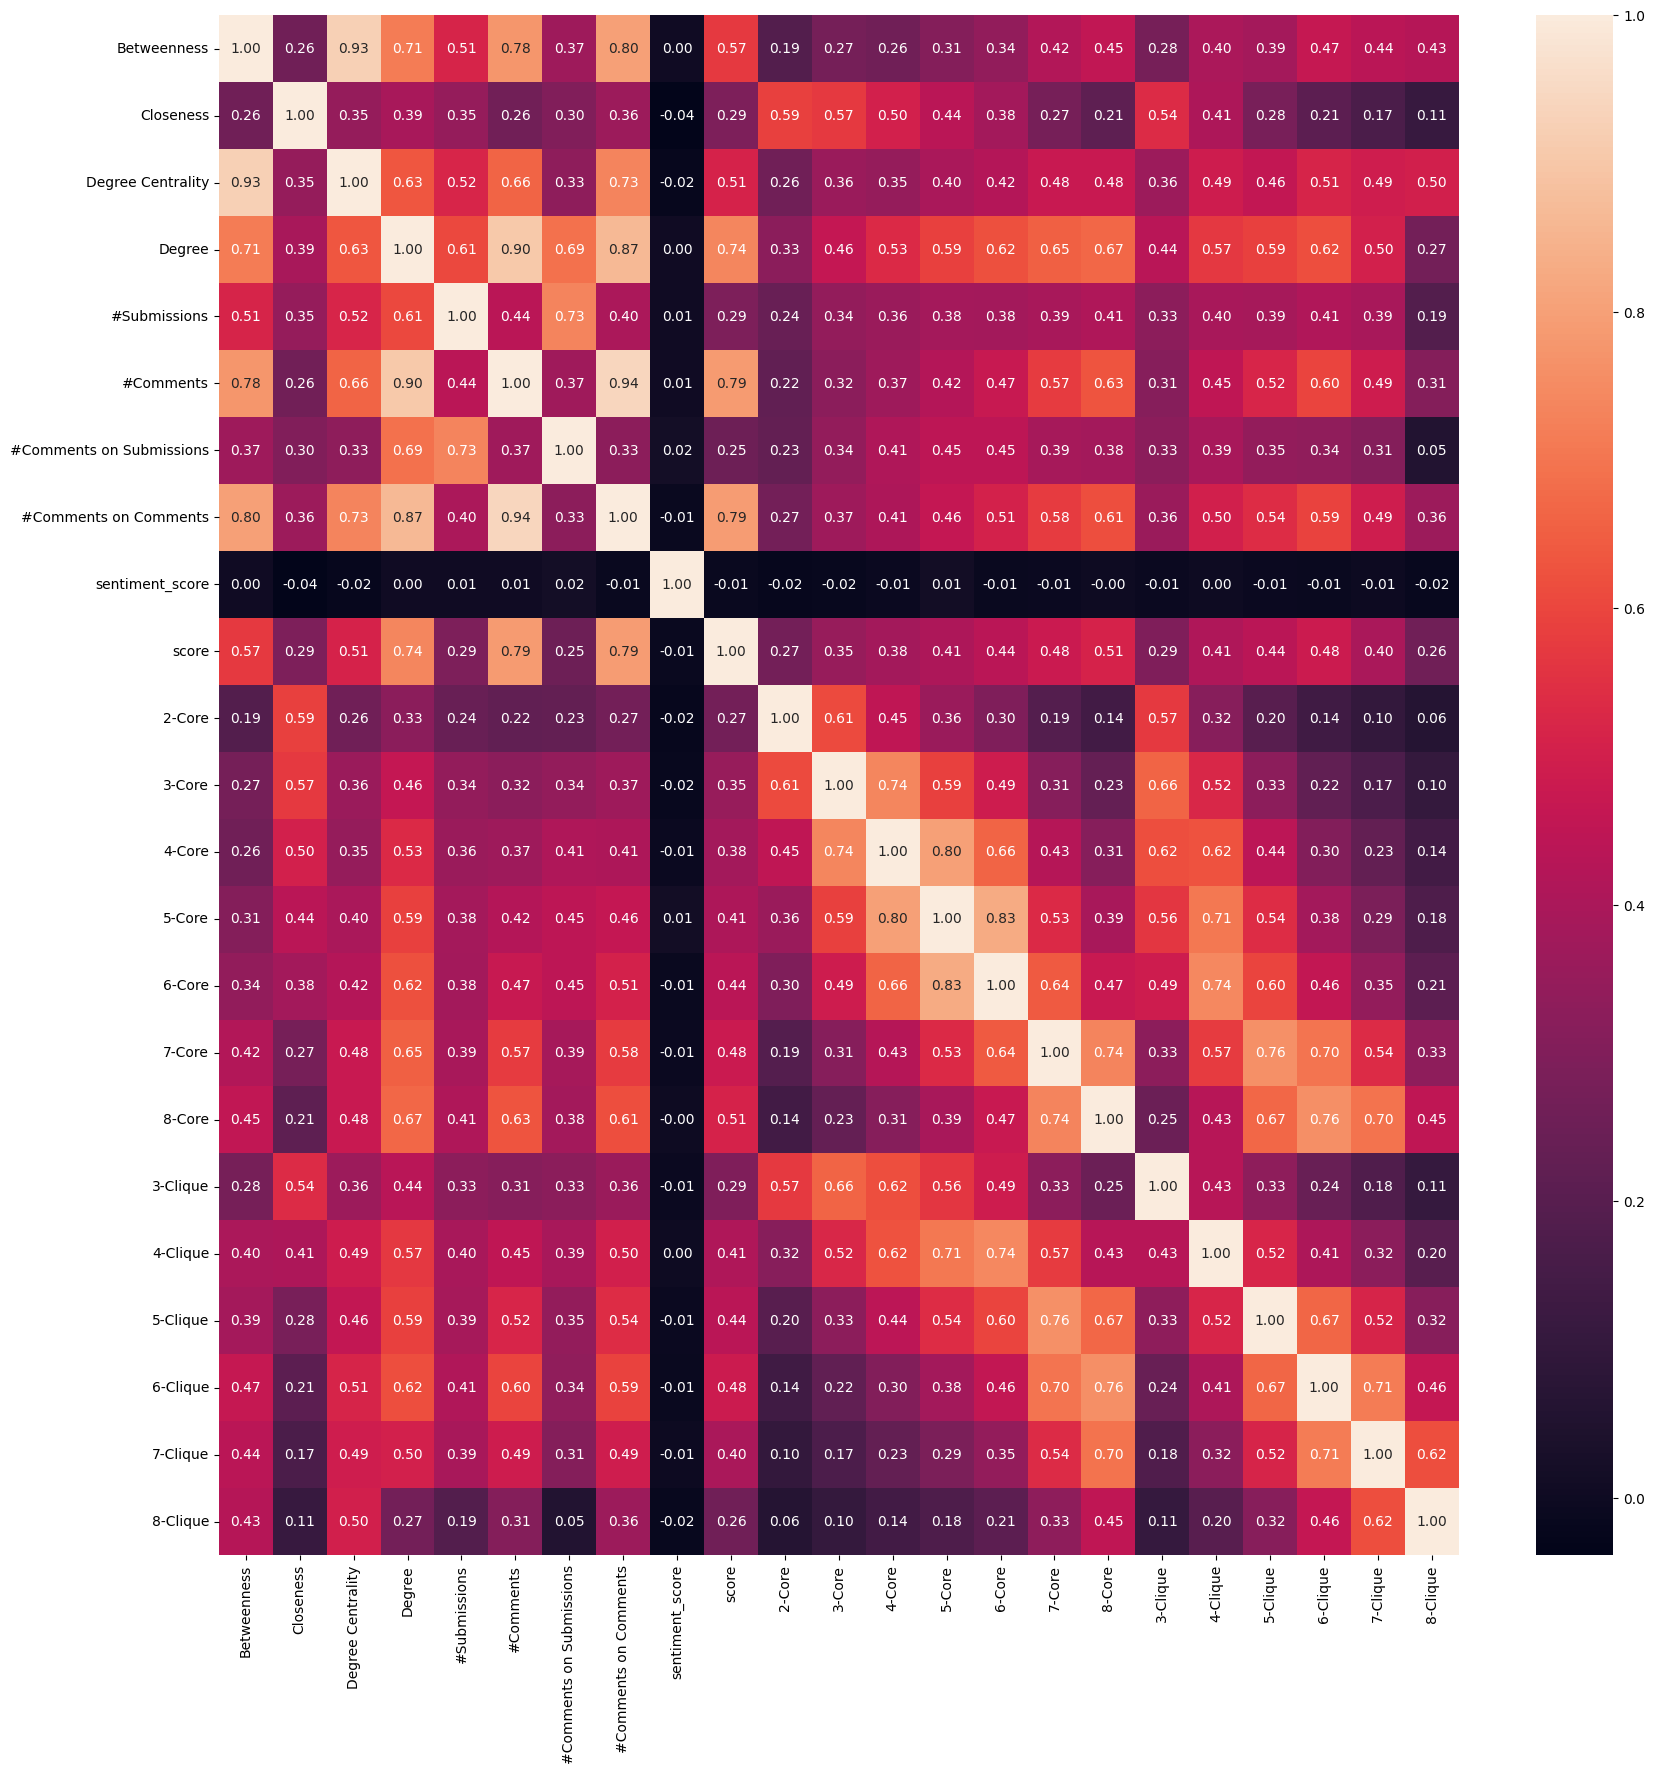

In [9]:
all_nodes = pd.concat([node_airing, node_post_airing, node_pre_release])

# Correlation matrix

correlation_matrix = all_nodes.drop('Node', axis=1).corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.show()

We notice that sentiment score is not correlated with other variables. All correlations are positive which is interresting

# Applying OLS on post_airing data

## Using Degree Centrality as the target

In [10]:
X_train = pd.concat([node_airing.drop(columns=['Node', 'Degree Centrality'], axis=1), node_pre_release.drop(columns=['Node', 'Degree Centrality'], axis=1)])
X_test = node_post_airing.drop(columns=['Node', 'Degree Centrality'], axis=1)
X_test = X_test[X_train.columns]
y_train = pd.concat([node_airing['Degree Centrality'], node_pre_release['Degree Centrality']])
y_test = node_post_airing['Degree Centrality']

# Lets apply OLS regression (linear regression) to predict Degree Centrality
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [11]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)

print('Mean Squared Error: ', mse)

# print coeficients next to each feature

print('Intercept :', model.intercept_)
coefs = pd.DataFrame(model.coef_, index=X_train.columns, columns=['Coef'])
# sort by coef absolute value
coefs = coefs.reindex(coefs['Coef'].abs().sort_values(ascending=False).index)
coefs

Mean Squared Error:  0.00014980823044990298
Intercept : 0.0018575298463836798


,Coef
Betweenness,1.956974e+00
8-Clique,1.831651e-02
6-Clique,1.026105e-02
7-Clique,7.230853e-03
7-Core,5.034629e-03
5-Clique,3.371498e-03
6-Core,3.342623e-03
4-Core,2.949131e-03
Closeness,2.894819e-03
5-Core,2.847201e-03


## Random Forest Feature importance

Mean Squared Error:  0.0007951540025832824


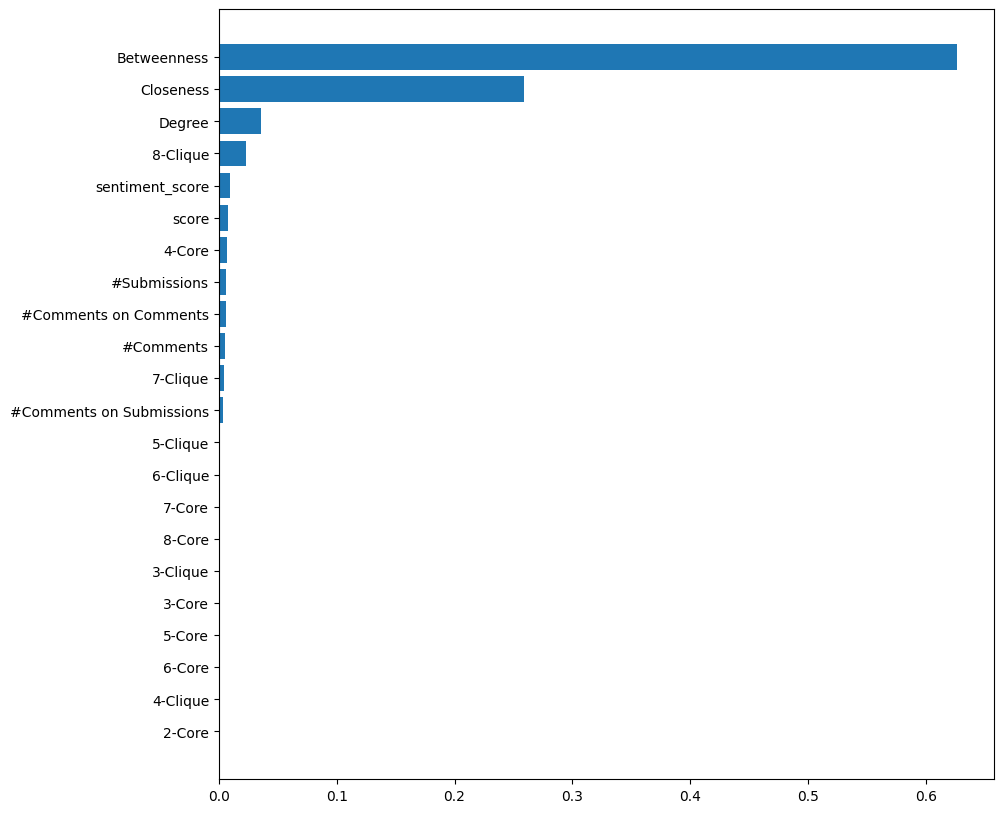

In [12]:
# Random Forest Regressor for feature importance

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print('Mean Squared Error: ', mse)

importances = model.feature_importances_

importances = pd.DataFrame(importances, index=X_train.columns, columns=['Importance'])
importances = importances.reindex(importances['Importance'].abs().sort_values(ascending=True).index)

# plot feature importances

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.barh(importances.index, importances['Importance'])
plt.show()

Degree Centrality seems linked to Betweeness so lets get rid of it

In [13]:
X_train = X_train.drop('Betweenness', axis=1)
X_test = X_test.drop('Betweenness', axis=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [14]:
mse = mean_squared_error(y_test, y_pred)

print('Mean Squared Error: ', mse)

# print coeficients next to each feature

print('Intercept :', model.intercept_)
coefs = pd.DataFrame(model.coef_, index=X_train.columns, columns=['Coef'])
# sort by coef absolute value
coefs = coefs.reindex(coefs['Coef'].abs().sort_values(ascending=False).index)
coefs

Mean Squared Error:  0.00139992221976318
Intercept : 0.0008936227668872102


,Coef
8-Clique,0.091648
6-Clique,0.014406
8-Core,-0.012345
7-Clique,0.006919
7-Core,0.006051
5-Clique,0.003892
5-Core,0.003188
4-Core,0.002015
#Submissions,0.001485
6-Core,0.001447


In [15]:
node_post_airing['Degree Centrality'].describe()

count    167.000000
mean       0.021283
std        0.041536
min        0.006024
25%        0.006024
50%        0.012048
75%        0.024096
max        0.415663
Name: Degree Centrality, dtype: float64

Mean Squared Error:  0.0013313686551333877


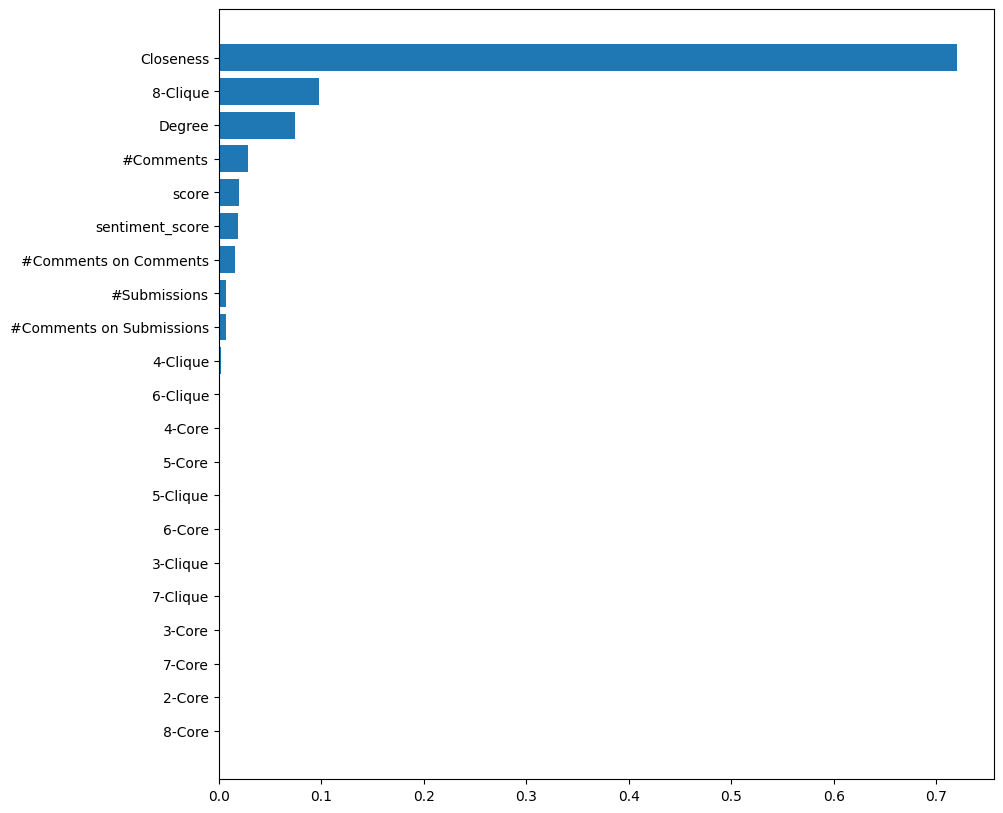

In [16]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print('Mean Squared Error: ', mse)

importances = model.feature_importances_

importances = pd.DataFrame(importances, index=X_train.columns, columns=['Importance'])
importances = importances.reindex(importances['Importance'].abs().sort_values(ascending=True).index)

# plot feature importances

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.barh(importances.index, importances['Importance'])
plt.show()

## OLS for score (reddit karma)

In [17]:
node_post_airing['score'].describe()

count    167.000000
mean      28.699187
std       50.813851
min      -10.000000
25%        4.000000
50%       15.000000
75%       28.699187
max      395.000000
Name: score, dtype: float64

In [18]:
X_train = pd.concat([node_airing.drop(columns=['Node', 'score'], axis=1), node_pre_release.drop(columns=['Node', 'score'], axis=1)])
X_test = node_post_airing.drop(columns=['Node', 'score'], axis=1)
X_test = X_test[X_train.columns]
y_train = pd.concat([node_airing['score'], node_pre_release['score']])
y_test = node_post_airing['score']

# Lets apply OLS regression (linear regression) to predict score
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [19]:
mse = mean_squared_error(y_test, y_pred)

print('Mean Squared Error: ', mse)

# rmse

rmse = np.sqrt(mse)

print('Root Mean Squared Error: ', rmse)

# print coeficients next to each feature

print('Intercept :', model.intercept_)
coefs = pd.DataFrame(model.coef_, index=X_train.columns, columns=['Coef'])
# sort by coef absolute value
coefs = coefs.reindex(coefs['Coef'].abs().sort_values(ascending=False).index)
coefs

Mean Squared Error:  1845.0750573602081
Root Mean Squared Error:  42.954336886514824
Intercept : 2.6610911336822554


,Coef
Betweenness,-1113.717545
7-Clique,31.238885
Degree Centrality,-26.376641
Closeness,-17.594762
8-Core,-17.591974
8-Clique,15.148616
3-Clique,-9.309472
6-Clique,-9.093819
5-Clique,-8.904329
7-Core,-8.250348


## RDF feature importance

Mean Squared Error:  2065.2079429800247


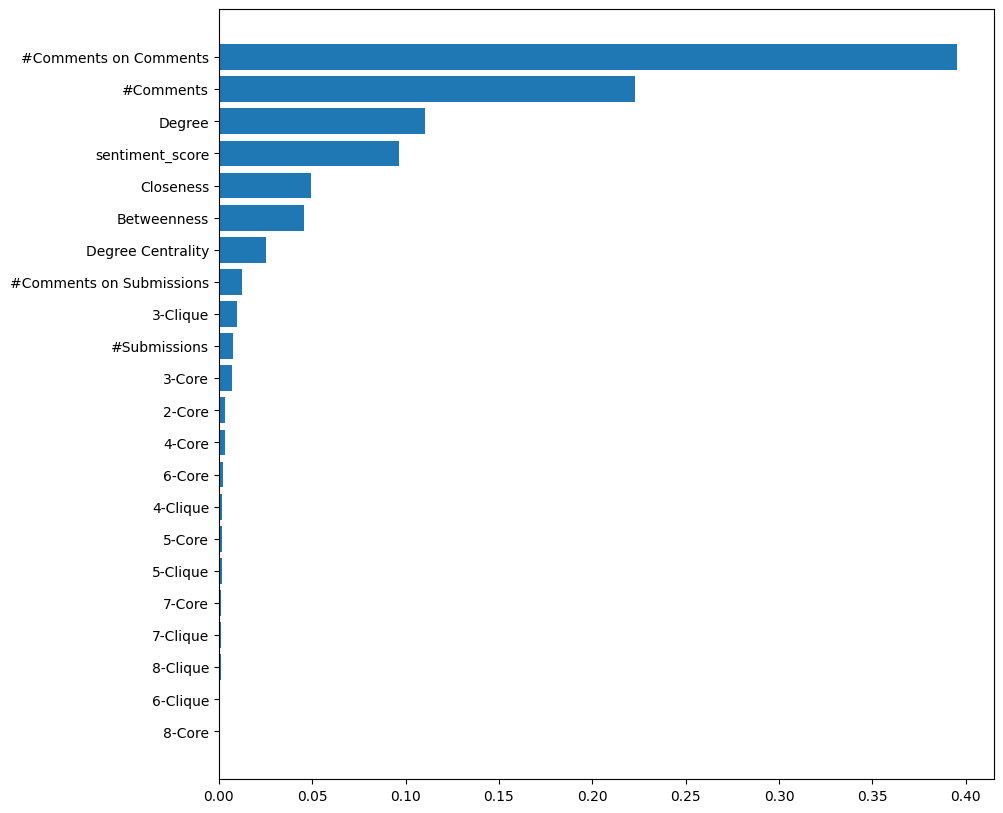

In [20]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print('Mean Squared Error: ', mse)

importances = model.feature_importances_

importances = pd.DataFrame(importances, index=X_train.columns, columns=['Importance'])
importances = importances.reindex(importances['Importance'].abs().sort_values(ascending=True).index)

# plot feature importances

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.barh(importances.index, importances['Importance'])
plt.show()

Despite the high RMSE score seems to be related to the number of comments. But it seems score cannot be explained by the network's properties.

# Creating an influence score

In [21]:
all_nodes = pd.concat(
    [node_airing, node_post_airing, node_pre_release],
    keys=['airing', 'post_airing', 'pre_release'] 
)
all_nodes.reset_index(level=0, inplace=True)
all_nodes.rename(columns={'level_0': 'original_dataset'}, inplace=True)
all_nodes['Node-network'] = all_nodes['Node'].astype(str) + '-' + all_nodes['original_dataset'].astype(str)
all_nodes.drop('original_dataset', axis=1)


,Node,Betweenness,Closeness,Degree Centrality,Degree,#Submissions,#Comments,#Comments on Submissions,#Comments on Comments,sentiment_score,...,6-Core,7-Core,8-Core,3-Clique,4-Clique,5-Clique,6-Clique,7-Clique,8-Clique,Node-network
0,The72nd,0.000000,0.000000,0.002941,1.0,0.0,1.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,The72nd-airing
1,BogerFrank981,0.002004,0.002941,0.005882,2.0,0.0,2.0,0.0,1.0,0.394950,...,0,0,0,0,0,0,0,0,0,BogerFrank981-airing
2,deepcontractor,0.046501,0.272048,0.111765,38.0,6.0,17.0,23.0,9.0,0.155741,...,1,0,0,1,1,0,0,0,0,deepcontractor-airing
3,thehornedlamb,0.002907,0.200262,0.011765,4.0,1.0,2.0,2.0,1.0,0.000000,...,0,0,0,0,0,0,0,0,0,thehornedlamb-airing
4,purpletube5678,0.000000,0.000000,0.002941,1.0,0.0,1.0,0.0,0.0,0.371600,...,0,0,0,0,0,0,0,0,0,purpletube5678-airing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,jeorjhejerome,0.000000,0.195907,0.001856,3.0,1.0,0.0,3.0,0.0,0.000000,...,0,0,0,1,0,0,0,0,0,jeorjhejerome-pre_release
1613,Mantissa_65,0.000000,0.000619,0.000619,1.0,1.0,0.0,1.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,Mantissa_65-pre_release
1614,SkoCubs01,0.000000,0.000619,0.000619,1.0,1.0,0.0,1.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,SkoCubs01-pre_release
1615,eunan08,0.000000,0.197548,0.005569,9.0,1.0,0.0,9.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,eunan08-pre_release


In [22]:
# Creating a clique score
all_nodes['clique score'] = all_nodes['3-Clique'] + all_nodes['4-Clique'] + all_nodes['5-Clique'] + all_nodes['6-Clique'] + all_nodes['7-Clique'] + all_nodes['8-Clique']

# Creating a core score
all_nodes['core score'] = all_nodes['2-Core'] + all_nodes['3-Core'] + all_nodes['4-Core'] + all_nodes['5-Core'] + all_nodes['6-Core'] + all_nodes['7-Core'] + all_nodes['8-Core']

# Creating an influence score
weights = {
    'Betweenness': 0.05,
    'Closeness': 0.05,
    'Degree Centrality': 0.3,
    '#Comments': 0.15,
    '#Submissions': 0.05,
    'score' : 0.2,
    'clique score': 0.1,
    'core score': 0.1
}

# List of columns to be normalized
columns_to_normalize = ['Betweenness', 'Closeness', 'Degree Centrality', '#Comments', '#Submissions', 'score', 'clique score', 'core score']

# Normalize these columns
for column in columns_to_normalize:
    min_col = all_nodes[column].min()
    max_col = all_nodes[column].max()
    all_nodes[column + '_norm'] = (all_nodes[column] - min_col) / (max_col - min_col)

# Calculate the influence score using the normalized values and specified weights
all_nodes['influence score'] = (
    all_nodes['Betweenness_norm'] * weights['Betweenness'] +
    all_nodes['Closeness_norm'] * weights['Closeness'] +
    all_nodes['Degree Centrality_norm'] * weights['Degree Centrality'] +
    all_nodes['#Comments_norm'] * weights['#Comments'] +
    all_nodes['#Submissions_norm'] * weights['#Submissions'] +
    all_nodes['score_norm'] * weights['score'] +
    all_nodes['clique score_norm'] * weights['clique score'] +
    all_nodes['core score_norm'] * weights['core score']
)

all_nodes

,original_dataset,Node,Betweenness,Closeness,Degree Centrality,Degree,#Submissions,#Comments,#Comments on Submissions,#Comments on Comments,...,core score,Betweenness_norm,Closeness_norm,Degree Centrality_norm,#Comments_norm,#Submissions_norm,score_norm,clique score_norm,core score_norm,influence score
0,airing,The72nd,0.000000,0.000000,0.002941,1.0,0.0,1.0,0.0,0.0,...,0,0.000000,0.000000,0.005595,0.004255,0.000000,0.061600,0.000000,0.000000,0.014637
1,airing,BogerFrank981,0.002004,0.002941,0.005882,2.0,0.0,2.0,0.0,1.0,...,0,0.009724,0.009858,0.012682,0.008511,0.000000,0.050400,0.000000,0.000000,0.016140
2,airing,deepcontractor,0.046501,0.272048,0.111765,38.0,6.0,17.0,23.0,9.0,...,5,0.225628,0.911807,0.267793,0.072340,0.272727,0.103200,0.333333,0.714286,0.287099
3,airing,thehornedlamb,0.002907,0.200262,0.011765,4.0,1.0,2.0,2.0,1.0,...,1,0.014104,0.671204,0.026855,0.008511,0.045455,0.050400,0.000000,0.142857,0.070237
4,airing,purpletube5678,0.000000,0.000000,0.002941,1.0,0.0,1.0,0.0,0.0,...,0,0.000000,0.000000,0.005595,0.004255,0.000000,0.051200,0.000000,0.000000,0.012557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,pre_release,jeorjhejerome,0.000000,0.195907,0.001856,3.0,1.0,0.0,3.0,0.0,...,1,0.000000,0.656608,0.002982,0.000000,0.045455,0.067678,0.166667,0.142857,0.080486
1613,pre_release,Mantissa_65,0.000000,0.000619,0.000619,1.0,1.0,0.0,1.0,0.0,...,0,0.000000,0.002074,0.000000,0.000000,0.045455,0.067678,0.000000,0.000000,0.015912
1614,pre_release,SkoCubs01,0.000000,0.000619,0.000619,1.0,1.0,0.0,1.0,0.0,...,0,0.000000,0.002074,0.000000,0.000000,0.045455,0.067678,0.000000,0.000000,0.015912
1615,pre_release,eunan08,0.000000,0.197548,0.005569,9.0,1.0,0.0,9.0,0.0,...,2,0.000000,0.662110,0.011928,0.000000,0.045455,0.067678,0.000000,0.285714,0.081064


In [23]:
# remove pandas column display limit

pd.set_option('display.max_columns', None)

sorted_nodes = all_nodes.sort_values(ascending=False, by='influence score')
sorted_nodes.head(20)

,original_dataset,Node,Betweenness,Closeness,Degree Centrality,Degree,#Submissions,#Comments,#Comments on Submissions,#Comments on Comments,sentiment_score,score,2-Core,3-Core,4-Core,5-Core,6-Core,7-Core,8-Core,3-Clique,4-Clique,5-Clique,6-Clique,7-Clique,8-Clique,Node-network,clique score,core score,Betweenness_norm,Closeness_norm,Degree Centrality_norm,#Comments_norm,#Submissions_norm,score_norm,clique score_norm,core score_norm,influence score
33,pre_release,AlbionsSeed,0.141958,0.285981,0.160891,260.0,11.0,235.0,71.0,120.0,0.126276,1189.0,1,1,1,1,1,1,1,1,1,1,1,1,0,AlbionsSeed-pre_release,5,7,0.688802,0.958504,0.386157,1.000000,0.500000,1.0000,0.833333,1.000000,0.756546
3,post_airing,AlbionsSeed,0.206095,0.272599,0.415663,69.0,7.0,103.0,7.0,67.0,0.078783,302.0,1,1,0,0,0,0,0,1,1,0,0,0,0,AlbionsSeed-post_airing,2,2,1.000000,0.913651,1.000000,0.438298,0.318182,0.2904,0.333333,0.285714,0.597321
472,pre_release,NonBelieverBeliever,0.083620,0.267671,0.107673,174.0,7.0,181.0,32.0,74.0,0.242639,849.0,1,1,1,1,1,1,1,1,1,1,1,0,0,NonBelieverBeliever-pre_release,4,7,0.405734,0.897134,0.257935,0.770213,0.318182,0.7280,0.666667,1.000000,0.586232
89,airing,Omar_Elattar,0.109303,0.297897,0.232353,79.0,1.0,100.0,2.0,71.0,0.089387,340.0,1,1,1,1,1,1,1,1,1,1,1,1,1,Omar_Elattar-airing,6,7,0.530351,0.998442,0.558337,0.425532,0.045455,0.3208,1.000000,1.000000,0.574203
17,airing,corpus-luteum,0.086917,0.298362,0.191176,65.0,3.0,63.0,4.0,37.0,-0.013992,242.0,1,1,1,1,1,1,1,1,1,1,1,1,1,corpus-luteum-airing,6,7,0.421734,1.000000,0.459127,0.268085,0.136364,0.2424,1.000000,1.000000,0.504336
121,airing,shannon26,0.048655,0.278790,0.155882,53.0,0.0,56.0,0.0,46.0,0.049470,532.0,1,1,1,1,1,1,1,1,1,1,1,1,1,shannon26-airing,6,7,0.236082,0.934402,0.374089,0.238298,0.000000,0.4744,1.000000,1.000000,0.501376
568,pre_release,RoadFlowerVIP,0.044650,0.258113,0.069307,112.0,6.0,115.0,15.0,37.0,0.014008,624.0,1,1,1,1,1,1,1,1,1,1,1,1,0,RoadFlowerVIP-pre_release,5,7,0.216647,0.865101,0.165496,0.489362,0.272727,0.5480,0.833333,1.000000,0.483710
8,airing,0ddbuttons,0.069628,0.265994,0.164706,56.0,0.0,47.0,0.0,25.0,0.330917,340.0,1,1,1,1,1,1,1,1,1,1,1,1,1,0ddbuttons-airing,6,7,0.337846,0.891516,0.395349,0.200000,0.000000,0.3208,1.000000,1.000000,0.474233
161,airing,SmallHeath555,0.059398,0.280837,0.170588,58.0,11.0,43.0,18.0,28.0,-0.049335,171.0,1,1,1,1,1,1,1,1,1,1,1,1,1,SmallHeath555-airing,6,7,0.288208,0.941263,0.409522,0.182979,0.500000,0.1856,1.000000,1.000000,0.473897
997,pre_release,farquharg,0.040393,0.254703,0.062500,101.0,0.0,113.0,0.0,60.0,0.034013,771.0,1,1,1,1,1,1,1,1,1,1,1,0,0,farquharg-pre_release,4,7,0.195990,0.853671,0.149096,0.480851,0.000000,0.6656,0.666667,1.000000,0.469126


In [24]:
# Print the top 10 influencers for each 'original_dataset' value

top_influencers_per_dataset = sorted_nodes.groupby('original_dataset').head(20)
top_influencers_per_dataset = top_influencers_per_dataset.sort_values(by=['original_dataset', 'influence score'], ascending=[True, False])
top_influencers_per_dataset

,original_dataset,Node,Betweenness,Closeness,Degree Centrality,Degree,#Submissions,#Comments,#Comments on Submissions,#Comments on Comments,sentiment_score,score,2-Core,3-Core,4-Core,5-Core,6-Core,7-Core,8-Core,3-Clique,4-Clique,5-Clique,6-Clique,7-Clique,8-Clique,Node-network,clique score,core score,Betweenness_norm,Closeness_norm,Degree Centrality_norm,#Comments_norm,#Submissions_norm,score_norm,clique score_norm,core score_norm,influence score
89,airing,Omar_Elattar,0.109303,0.297897,0.232353,79.0,1.0,100.0,2.0,71.0,0.089387,340.0,1,1,1,1,1,1,1,1,1,1,1,1,1,Omar_Elattar-airing,6,7,0.530351,0.998442,0.558337,0.425532,0.045455,0.3208,1.000000,1.000000,0.574203
17,airing,corpus-luteum,0.086917,0.298362,0.191176,65.0,3.0,63.0,4.0,37.0,-0.013992,242.0,1,1,1,1,1,1,1,1,1,1,1,1,1,corpus-luteum-airing,6,7,0.421734,1.000000,0.459127,0.268085,0.136364,0.2424,1.000000,1.000000,0.504336
121,airing,shannon26,0.048655,0.278790,0.155882,53.0,0.0,56.0,0.0,46.0,0.049470,532.0,1,1,1,1,1,1,1,1,1,1,1,1,1,shannon26-airing,6,7,0.236082,0.934402,0.374089,0.238298,0.000000,0.4744,1.000000,1.000000,0.501376
8,airing,0ddbuttons,0.069628,0.265994,0.164706,56.0,0.0,47.0,0.0,25.0,0.330917,340.0,1,1,1,1,1,1,1,1,1,1,1,1,1,0ddbuttons-airing,6,7,0.337846,0.891516,0.395349,0.200000,0.000000,0.3208,1.000000,1.000000,0.474233
161,airing,SmallHeath555,0.059398,0.280837,0.170588,58.0,11.0,43.0,18.0,28.0,-0.049335,171.0,1,1,1,1,1,1,1,1,1,1,1,1,1,SmallHeath555-airing,6,7,0.288208,0.941263,0.409522,0.182979,0.500000,0.1856,1.000000,1.000000,0.473897
66,airing,NonBelieverBeliever,0.069930,0.280425,0.150000,51.0,5.0,47.0,12.0,21.0,0.104230,286.0,1,1,1,1,1,1,1,1,1,1,1,1,1,NonBelieverBeliever-airing,6,7,0.339310,0.939883,0.359917,0.200000,0.227273,0.2776,1.000000,1.000000,0.468818
112,airing,emilythewise,0.030332,0.275180,0.123529,42.0,0.0,34.0,0.0,22.0,-0.436268,237.0,1,1,1,1,1,1,1,1,1,1,1,1,1,emilythewise-airing,6,7,0.147176,0.922302,0.296139,0.144681,0.000000,0.2384,1.000000,1.000000,0.411698
36,airing,Atharva1399,0.032381,0.285022,0.100000,34.0,7.0,21.0,12.0,14.0,0.121152,112.0,1,1,1,1,1,1,1,1,1,1,1,1,1,Atharva1399-airing,6,7,0.157116,0.955291,0.239447,0.089362,0.318182,0.1384,1.000000,1.000000,0.384448
246,airing,doraShelby,0.016289,0.248377,0.097059,33.0,6.0,43.0,13.0,21.0,0.494095,131.0,1,1,1,1,1,1,1,1,1,1,1,1,0,doraShelby-airing,5,7,0.079035,0.832468,0.232361,0.182979,0.272727,0.1536,0.833333,1.000000,0.370420
50,airing,Illegal_alien4,0.026155,0.258446,0.085294,29.0,0.0,20.0,0.0,20.0,-0.198660,317.0,1,1,1,1,1,1,0,1,1,1,1,0,0,Illegal_alien4-airing,4,6,0.126910,0.866216,0.204015,0.085106,0.000000,0.3024,0.666667,0.857143,0.336488


In [25]:
filtered_nodes = top_influencers_per_dataset[top_influencers_per_dataset['influence score'] > 0.3]

grouped_nodes = filtered_nodes.groupby('original_dataset')['Node'].apply(list)

nodes_airing = grouped_nodes.get('airing', [])
nodes_post_airing = grouped_nodes.get('post_airing', [])
nodes_pre_release = grouped_nodes.get('pre_release', [])

In [28]:
print('Top influencers for airing dataset:')
print(nodes_airing)
print('number of influencers:', len(nodes_airing))
print('Top influencers for post_airing dataset:')
print(nodes_post_airing)
print('number of influencers:', len(nodes_post_airing))
print('Top influencers for pre_release dataset:')
print(nodes_pre_release)
print('number of influencers:', len(nodes_pre_release))

Top influencers for airing dataset:
['Omar_Elattar', 'corpus-luteum', 'shannon26', '0ddbuttons', 'SmallHeath555', 'NonBelieverBeliever', 'emilythewise', 'Atharva1399', 'doraShelby', 'Illegal_alien4', 'farquharg', 'janinasheart', 'haloryder', 'Peakygirl']
number of influencers: 14
Top influencers for post_airing dataset:
['AlbionsSeed', 'NonBelieverBeliever', 'Omar_Elattar']
number of influencers: 3
Top influencers for pre_release dataset:
['AlbionsSeed', 'NonBelieverBeliever', 'RoadFlowerVIP', 'farquharg', 'SmallHeath555', 'donkeybrainfrank', 'slick-daddy-69', 'Niks_kashyap', 'harambeazn', '0ddbuttons', 'maychi']
number of influencers: 11


In [29]:
# influencers in all 3 datasets
influencers_all_datasets = set(nodes_airing) & set(nodes_post_airing) & set(nodes_pre_release)
print('Influencers in all 3 datasets:')
print(influencers_all_datasets)

Influencers in all 3 datasets:
{'NonBelieverBeliever'}


# Loading the graphs

In [26]:
import pickle

with open('networks/pre_release_network.pkl', 'rb') as f:
    G1 = pickle.load(f)
 
with open('networks/airing_network.pkl', 'rb') as f:
    G2 = pickle.load(f)
 
with open('networks/post_airing_network.pkl', 'rb') as f:
    G3 = pickle.load(f)

# Plotting the top users with the highest influence score

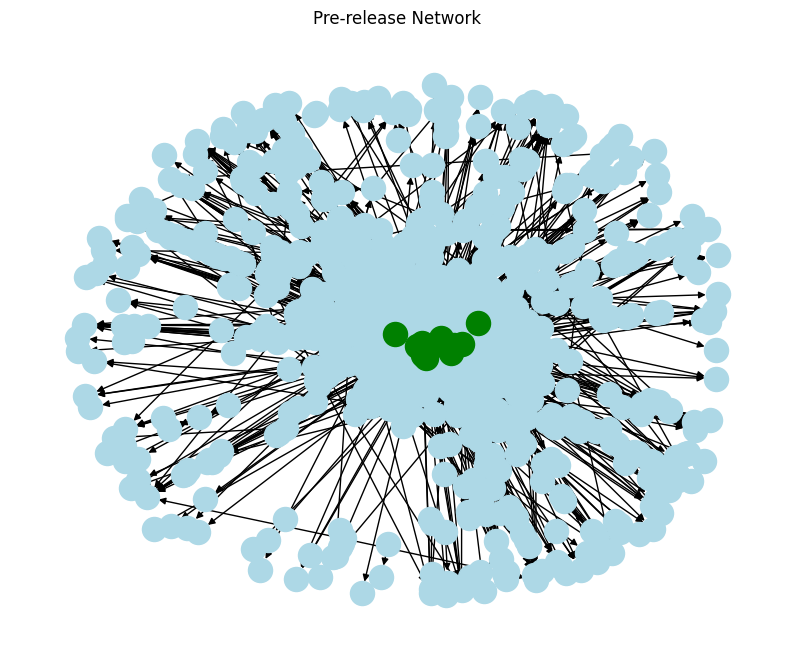

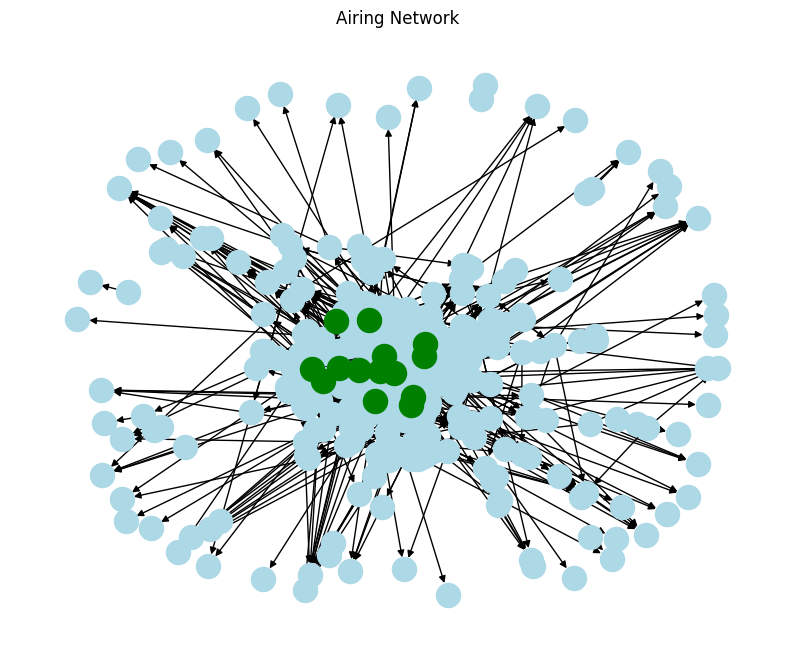

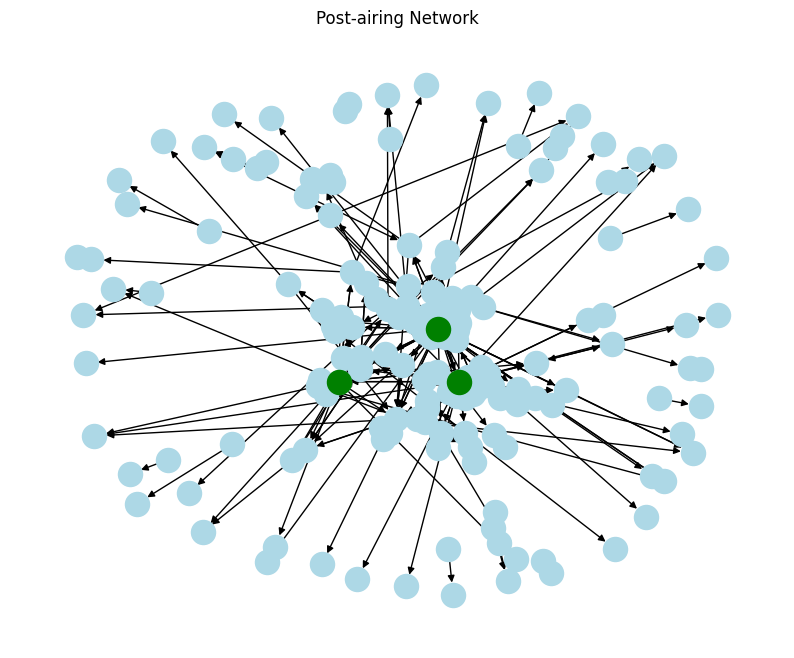

In [27]:

import networkx as nx

# Helper function to plot a graph with specific nodes highlighted in green
def plot_graph(G, highlighted_nodes, title):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # positions for all nodes
    
    # Draw all nodes with a default color and specific nodes in green
    nx.draw_networkx_nodes(G, pos, node_color='lightblue')  # Draw all nodes
    nx.draw_networkx_nodes(G, pos, nodelist=highlighted_nodes, node_color='green')  # Highlighted nodes in green
    
    # Draw edges and labels
    nx.draw_networkx_edges(G, pos)
    
    plt.title(title)
    plt.axis('off')  # Turn off the axis
    plt.show()

# Plotting each graph
plot_graph(G1, nodes_pre_release, 'Pre-release Network')
plot_graph(G2, nodes_airing, 'Airing Network')
plot_graph(G3, nodes_post_airing, 'Post-airing Network')
